<a href="https://colab.research.google.com/github/wedexyz/eeg-/blob/main/AV1_komparasi_ML%2CLSTM%2CCNN%2BReduceLe%2BCrossVall%2BROcVS4_8chanel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential,load_model
from keras.layers import LSTM
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
import pandas as pd
import os
import random
import time
import os


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau


from scipy import signal
from scipy.fft import fftshift



# DATA

In [40]:
ACTIONS = ["kiri", "maju","idle","kanan"]
#reshape = (-1,16, 60,1)
reshape = (-1,8, 60,1)
reshape2 = (-1,8, 60)
reshape3 = (-1,8, 60)
#reshape(-1,28,28,1)




In [41]:
def create_data(starting_dir="/content/drive/MyDrive/Colab Notebooks/data8"):
    training_data = {}
    for action in ACTIONS:
        if action not in training_data:
            training_data[action] = []
        data_dir = os.path.join(starting_dir,action)
        for item in os.listdir(data_dir):
            data = np.load(os.path.join(data_dir, item))
            for item in data:
                training_data[action].append(item)

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)

    for action in ACTIONS:
        np.random.shuffle(training_data[action])  
        training_data[action] = training_data[action][:min(lengths)]

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)
    combined_data = []
    for action in ACTIONS:
        for data in training_data[action]:
            if action == "kiri":
                combined_data.append([data, [1, 0, 0,0]])
            elif action == "maju":
                combined_data.append([data, [0, 1, 0, 0]])
            elif action == "idle":
                combined_data.append([data, [0, 0, 1, 0]])
            elif action == "kanan":
                combined_data.append([data, [0, 0, 0, 1]])

    np.random.shuffle(combined_data)
    print("length:",len(combined_data))
    return combined_data


In [42]:
print("creating training data")
traindata = create_data(starting_dir="/content/drive/MyDrive/Colab Notebooks/data8")
train_X = []
train_y = []

for X, y in traindata:
    train_X.append(X)
    train_y.append(y)

train_X = np.array(train_X).reshape(reshape)
train2_X = np.array(train_X).reshape(reshape2)

train_y = np.array(train_y)


creating training data
[250, 250, 250, 250]
[250, 250, 250, 250]
length: 1000


In [43]:

idle = np.load("/content/drive/MyDrive/Colab Notebooks/data8/idle/1608706768.npy")
kanan = np.load("/content/drive/MyDrive/Colab Notebooks/data8/kanan/1608707012.npy")
kiri = np.load("/content/drive/MyDrive/Colab Notebooks/data8/kiri/1608707050.npy")
maju = np.load("/content/drive/MyDrive/Colab Notebooks/data8/maju/1608706976.npy")

kelas1=idle[0][16]
kelas2=maju[0][16]
kelas3=kanan[0][16]
kelas4=kiri[0][16]

kelas1a=idle[175]
kelas2a=maju[175]
kelas3a=kanan[175]
kelas4a=kiri[175]



f1, t1,Sxx= signal.spectrogram(kelas1,fs=60, window=('tukey', 0.25),
                             nperseg=2,
                             noverlap=1,
                             nfft=None, 
                             detrend='constant',
                             return_onesided=True, 
                             scaling='density', 
                             axis=-1,
                             mode='psd',
                            )
dbs1 = 10*np.log10(Sxx)
f2, t2,Sxx= signal.spectrogram(kelas2,fs=120, window=('tukey', 0.25),
                             nperseg=2,
                             noverlap=1,
                             nfft=None, 
                             detrend='constant',
                             return_onesided=True, 
                             scaling='density', 
                             axis=-1,
                             mode='psd',
                            )
dbs2 = 10*np.log10(Sxx)
f3, t3,Sxx= signal.spectrogram(kelas3,fs=120, window=('tukey', 0.25),
                             nperseg=2,
                             noverlap=1,
                             nfft=None, 
                             detrend='constant',
                             return_onesided=True, 
                             scaling='density', 
                             axis=-1,
                             mode='psd'
                            )
dbs3 = 10*np.log10(Sxx)
f4, t4,Sxx= signal.spectrogram(kelas4,fs=120, window=('tukey', 0.25),
                             nperseg=2,
                             noverlap=1,
                             nfft=None, 
                             detrend='constant',
                             return_onesided=True, 
                             scaling='density', 
                             axis=-1,
                             mode='psd'
                            )  
dbs4 = 10*np.log10(Sxx)



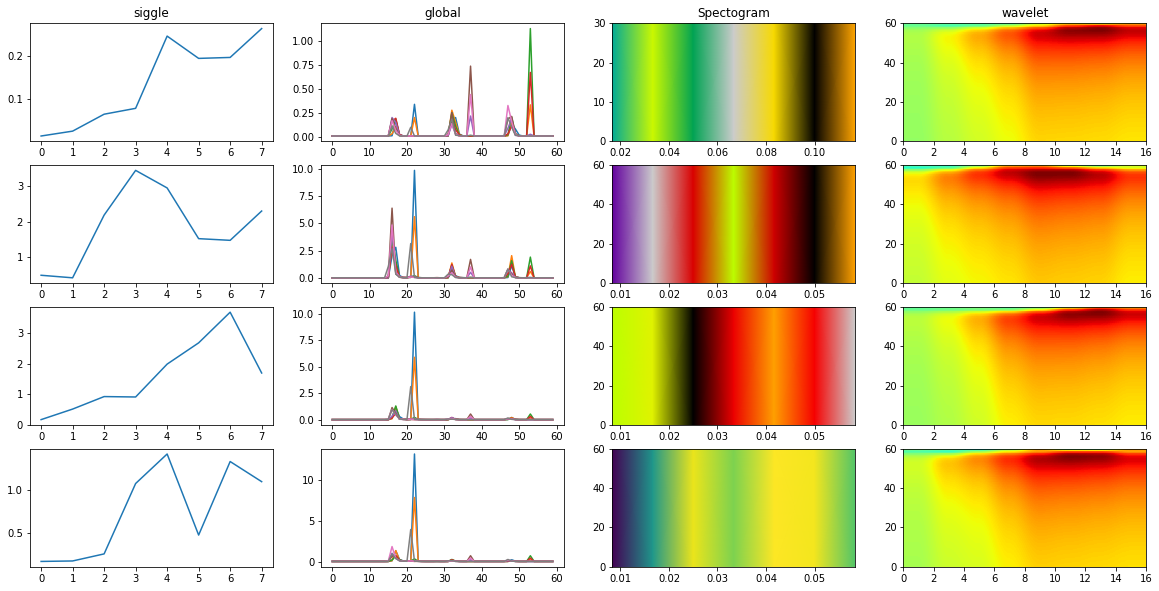

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(20,10))
axs = axs.flatten()

axs[0].set_title("siggle")
axs[0].plot(kelas1)

axs[1].set_title("global")
axs[1].plot(kelas1a)

axs[2].set_title("Spectogram")
axs[2].pcolormesh(t1, f1,dbs1,  
                  shading='gouraud',
                  cmap='nipy_spectral')

cwt1 = signal.cwt(kelas1,signal.ricker,widths=np.arange(1,50))
cwt2 = signal.cwt(kelas2,signal.ricker,widths=np.arange(1,50))
cwt3 = signal.cwt(kelas3,signal.ricker,widths=np.arange(1,50))
cwt4 = signal.cwt(kelas4,signal.ricker,widths=np.arange(1,50))
axs[3].set_title("wavelet")
axs[3].imshow(cwt1,extent=[0,16,0,60],cmap='jet',aspect='auto',vmax=abs(cwt1).max(),vmin=-abs(cwt1).max())

axs[4].plot(kelas2)
axs[5].plot(kelas2a)
axs[6].pcolormesh(t2, f2,dbs2,  
                  shading='gouraud',
                  cmap='nipy_spectral')
axs[7].imshow(cwt2,extent=[0,16,0,60],cmap='jet',aspect='auto',vmax=abs(cwt2).max(),vmin=-abs(cwt2).max())

axs[8].plot(kelas3)
axs[9].plot(kelas3a)
axs[10].pcolormesh(t3, f3,dbs3,  
                  shading='gouraud',
                  cmap='nipy_spectral')
axs[11].imshow(cwt3,extent=[0,16,0,60],cmap='jet',aspect='auto',vmax=abs(cwt3).max(),vmin=-abs(cwt3).max())

axs[12].plot(kelas4)
axs[13].plot(kelas4a)
axs[14].pcolormesh(t4, f4,dbs4,  
                  shading='gouraud',
                  cmap='viridis')
axs[15].imshow(cwt4,extent=[0,16,0,60],cmap='jet',aspect='auto',vmax=abs(cwt4).max(),vmin=-abs(cwt4).max())
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


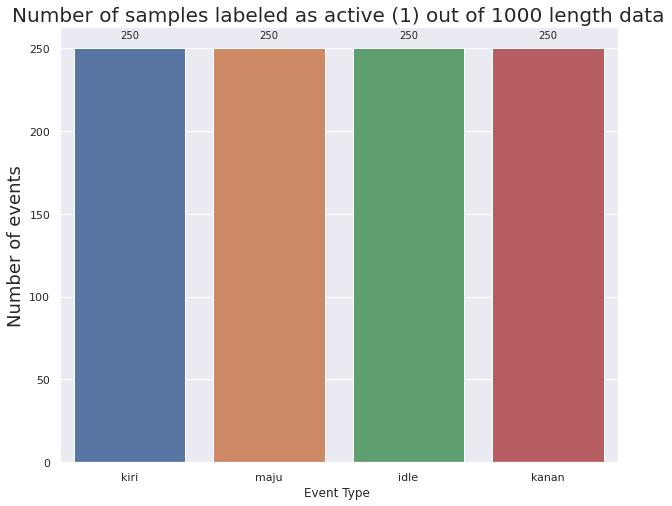

In [8]:

import seaborn as sns
ye=pd.DataFrame(train_y)

ye.columns=["kiri", "maju","idle","kanan"]
categories = list(ye.columns.values)
sns.set(font_scale = 1)
plt.figure(figsize=(10,8))
ax= sns.barplot(categories, ye.iloc[:,0:].sum().values)
plt.title("Number of samples labeled as active (1) out of {0} length data".format((ye.shape[0])),fontsize=20)

plt.ylabel('Number of events', fontsize=18)
plt.xlabel('Event Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = ye.iloc[:,0:].sum().values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

# CNN

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.5, min_lr=0.0001)

In [10]:
#def cnn_model(size, num_cnn_layers):

def cnn_model():    

    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (8,8), padding = "same", activation = "relu", input_shape=train_X.shape[1:]))
    model.add(MaxPooling2D(pool_size = (4,4)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters = 64, kernel_size = (4,4), padding = "same", activation = "relu",input_shape=train_X.shape[1:]))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters = 64, kernel_size = (2,2), padding = "same", activation = "relu",input_shape=train_X.shape[1:]))
    model.add(MaxPooling2D(pool_size = (1,1)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dense(32, activation = "relu"))
    model.add(BatchNormalization())
    
    model.add(Dense(4, activation = "sigmoid"))
   
    #adam = Adam(lr = 0.001)
    model.compile(optimizer ="adam", loss = "binary_crossentropy", 
                  metrics = ['accuracy',tf.keras.metrics.AUC(),
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.PrecisionAtRecall(0.5),
                             tf.keras.metrics.SpecificityAtSensitivity(0.5),
                             tf.keras.metrics.SensitivityAtSpecificity(0.5)

                             ])
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
    
    return model


In [11]:

model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 60, 64)         4160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 15, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 15, 64)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 15, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 15, 64)         65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 7, 64)          0

In [12]:
#set early stopping criteria
pat = 5
#this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('subjek1CNN.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=100, BATCH_SIZE=32):
    model = None
    model = cnn_model() 
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction,early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)   
    print("Val Score: ", model.evaluate(val_x, val_y))
    
    return results

In [13]:
n_folds=5
epochs=100
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(train_X, train_y, test_size=0.2, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
   
    print("======="*12, end="\n\n\n")


Training on Fold:  1
Epoch 1/100
23/23 [==============================] - 10s 56ms/step - loss: 0.7820 - accuracy: 0.3699 - auc_1: 0.6270 - precision_1: 0.3219 - precision_at_recall_1: 0.3538 - specificity_at_sensitivity_1: 0.6867 - sensitivity_at_specificity_1: 0.6808 - val_loss: 0.6298 - val_accuracy: 0.6250 - val_auc_1: 0.7793 - val_precision_1: 0.5464 - val_precision_at_recall_1: 0.6774 - val_specificity_at_sensitivity_1: 0.9167 - val_sensitivity_at_specificity_1: 0.8125

Epoch 00001: val_loss improved from inf to 0.62985, saving model to subjek1CNN.h5
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.5719 - accuracy: 0.5717 - auc_1: 0.8011 - precision_1: 0.4324 - precision_at_recall_1: 0.5917 - specificity_at_sensitivity_1: 0.8840 - sensitivity_at_specificity_1: 0.8625 - val_loss: 0.5609 - val_accuracy: 0.6250 - val_auc_1: 0.8349 - val_precision_1: 0.6000 - val_precision_at_recall_1: 0.6557 - val_specificity_at_sensitivity_1: 0.9125 - val_sensitivity_at_s

In [14]:

print("data train x",t_x.shape)
print("data train y",t_y.shape)

print("data tes x",val_x.shape)
print("data tes y",val_y.shape)

model = load_model('subjek1CNN.h5')
#model.evaluate(val_x, val_y)
a = model.evaluate(val_x, val_y)
print('loss',a[0])
print('Accuracy',a[1])
print('AUC',a[2])
print('precision',a[3])
print('recall',a[4])
print('specificity_at_sensitivity',a[5])
print('sensitivity_at_specificity',a[6])

data train x (800, 8, 60, 1)
data train y (800, 4)
data tes x (200, 8, 60, 1)
data tes y (200, 4)
7/7 [==============================] - 1s 7ms/step - loss: 0.0507 - accuracy: 0.9700 - auc_5: 0.9989 - precision_5: 0.9697 - precision_at_recall_5: 1.0000 - specificity_at_sensitivity_5: 1.0000 - sensitivity_at_specificity_5: 1.0000
loss 0.05071229115128517
Accuracy 0.9700000286102295
AUC 0.9988666772842407
precision 0.9696969985961914
recall 1.0
specificity_at_sensitivity 1.0
sensitivity_at_specificity 1.0


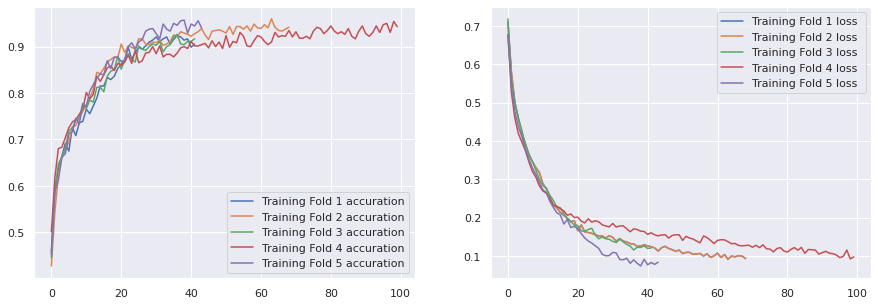

In [15]:
fig, (ax1, ax2) =  plt.subplots( ncols=2, sharex=True)
ax1.plot(model_history[0].history['accuracy'], label='Training Fold 1 accuration')
ax1.plot(model_history[1].history['accuracy'], label='Training Fold 2 accuration')
ax1.plot(model_history[2].history['accuracy'], label='Training Fold 3 accuration')
ax1.plot(model_history[3].history['accuracy'], label='Training Fold 4 accuration')
ax1.plot(model_history[4].history['accuracy'], label='Training Fold 5 accuration')
ax1.legend()
ax2.plot(model_history[1].history['loss'], label='Training Fold 1 loss')
ax2.plot(model_history[1].history['loss'], label='Training Fold 2 loss')
ax2.plot(model_history[2].history['loss'], label='Training Fold 3 loss')
ax2.plot(model_history[3].history['loss'], label='Training Fold 4 loss ')
ax2.plot(model_history[4].history['loss'], label='Training Fold 5 loss')
ax2.legend()
plt.show()

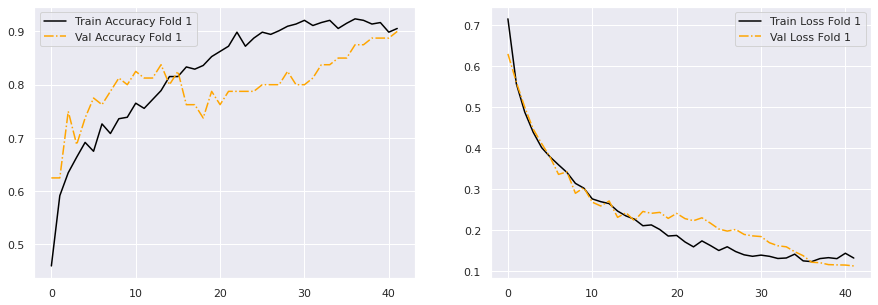

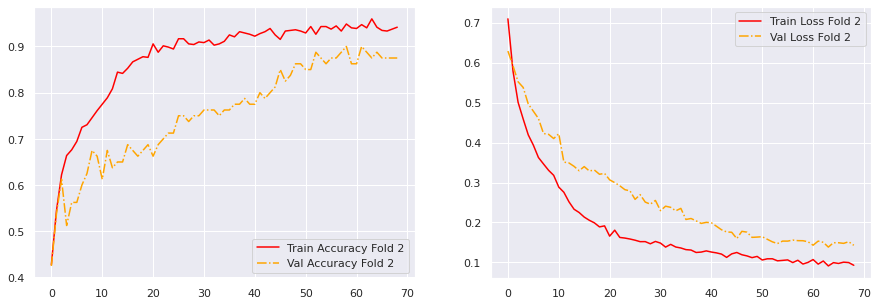

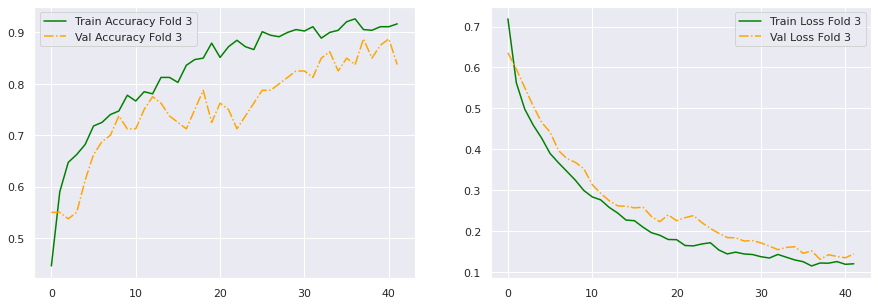

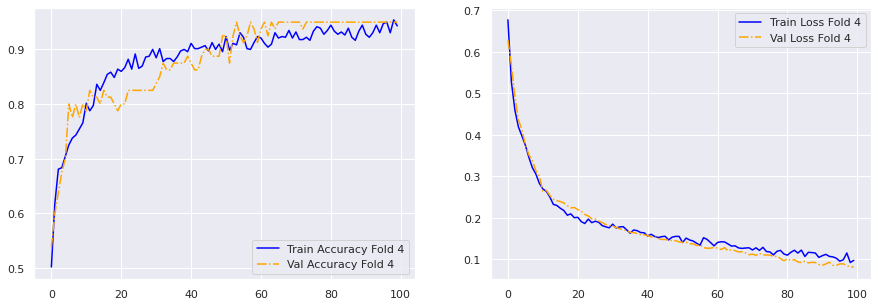

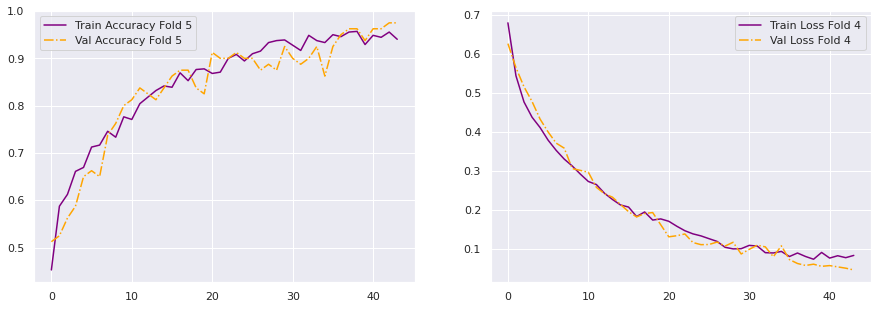

In [16]:

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt1.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt2.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red')
plt1.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red')
plt2.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green')
plt1.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green')
plt2.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()


fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue')
plt1.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue')
plt2.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='purple')
plt1.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[4].history['loss'], label='Train Loss Fold 4', color='purple')
plt2.plot(model_history[4].history['val_loss'], label='Val Loss Fold 4', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

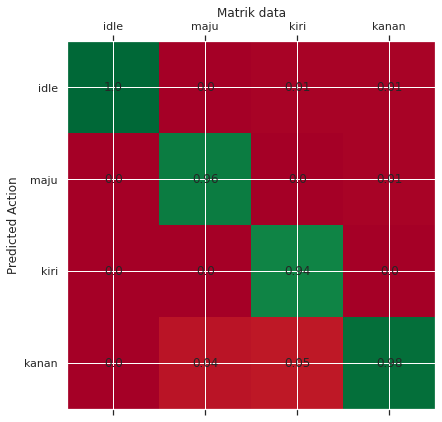

In [17]:

MODEL_NAME ='/content/subjek1CNN.h5' 

#CLIP = True # if your model was trained with np.clip to clip  values
CLIP = False
CLIP_VAL = 8  # if above, what was the value +/-

model = tf.keras.models.load_model(MODEL_NAME)

VALDIR = '/content/drive/MyDrive/Colab Notebooks/data8'
ACTIONS =  ["idle","maju","kiri", "kanan"]
PRED_BATCH = 32


def get_val_data(valdir, action, batch_size):

   # argmax_dict = {0: 0, 1: 0, 2: 0,3:0}
    argmax_dict = {2: 0, 0: 0, 1: 0,3:0}
    raw_pred_dict = {0: 0, 1: 0, 2: 0,3:0}

    action_dir = os.path.join(valdir, action)
    for session_file in os.listdir(action_dir):
        filepath = os.path.join(action_dir,session_file)
        if CLIP:
            data = np.clip(np.load(filepath), -CLIP_VAL, CLIP_VAL) / CLIP_VAL
            #print(data)
        else:
            data = np.load(filepath) 
        preds = model.predict([data.reshape(-1, 8, 60,1)], batch_size=batch_size)
        
        for pred in preds:
            argmax = np.argmax(pred)
            argmax_dict[argmax] += 1
            for idx,value in enumerate(pred):
                raw_pred_dict[idx] += value
    
    argmax_pct_dict = {}
    for i in argmax_dict:
        total = 0
        correct = argmax_dict[i]
        for ii in argmax_dict:
            total += argmax_dict[ii]
        argmax_pct_dict[i] = round(correct/total, 4)
    return argmax_dict, raw_pred_dict, argmax_pct_dict


def make_conf_mat(none,left,forward, right):
    action_dict = {"idle":none,"maju": forward, "kiri": left, "kanan": right}
    action_conf_mat = pd.DataFrame(action_dict)
    actions = [i for i in action_dict]

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    ax.matshow(action_conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    for idx, i in enumerate(action_dict):
        for idx2, ii in enumerate(action_dict[i]):
            ax.text(idx, idx2, f"{round(float(action_dict[i][ii]),2)}", va='center', ha='center')
    # Rotate the tick labels and set their alignment.
    
    plt.title("Matrik data")
    plt.ylabel("Predicted Action")
    fig.tight_layout()
    plt.show()



forward_argmax_dict, forward_raw_pred_dict, forward_argmax_pct_dict = get_val_data(VALDIR, "maju", PRED_BATCH)
none_argmax_dict, none_raw_pred_dict, none_argmax_pct_dict = get_val_data(VALDIR, "idle", PRED_BATCH)
left_argmax_dict, left_raw_pred_dict, left_argmax_pct_dict = get_val_data(VALDIR, "kiri", PRED_BATCH)
right_argmax_dict, right_raw_pred_dict, right_argmax_pct_dict = get_val_data(VALDIR, "kanan", PRED_BATCH)
make_conf_mat(none_argmax_pct_dict,forward_argmax_pct_dict,left_argmax_pct_dict,  right_argmax_pct_dict)



In [18]:
x_train,x_test,y_train,y_test=train_test_split(train_X,train_y,test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 8, 60, 1)
(200, 8, 60, 1)
(800, 4)
(200, 4)


roc_auc: 0.9988047769443348


<Figure size 1080x360 with 0 Axes>

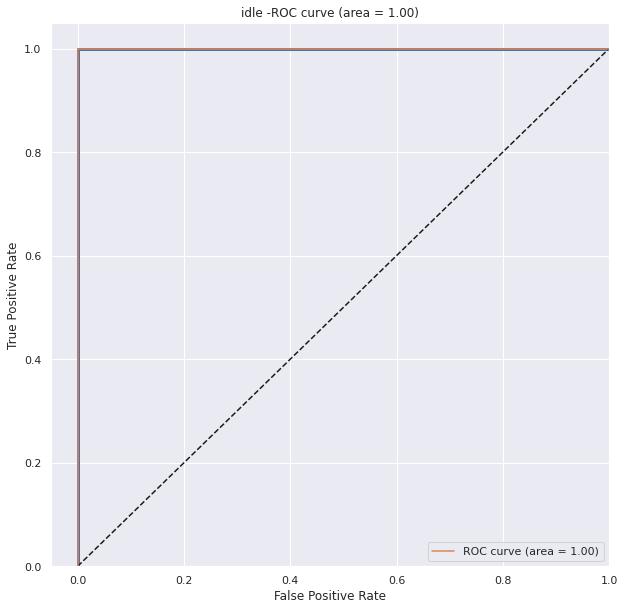

<Figure size 1080x360 with 0 Axes>

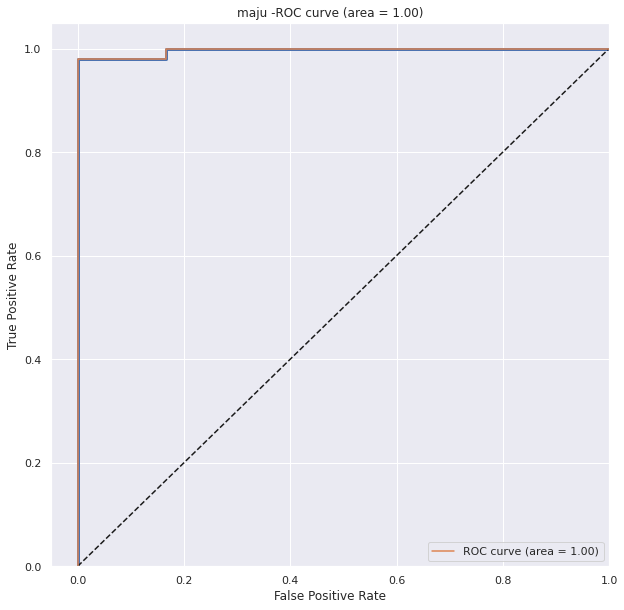

<Figure size 1080x360 with 0 Axes>

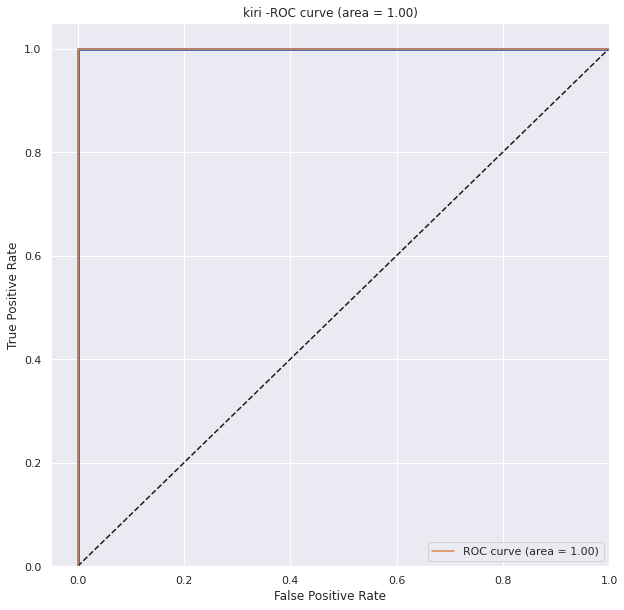

<Figure size 1080x360 with 0 Axes>

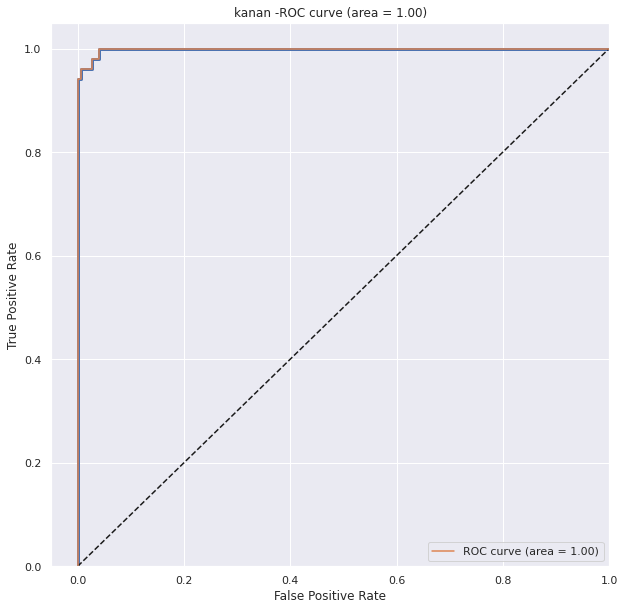

In [19]:
from sklearn.metrics import roc_curve, auc

#y_score = clf.decision_function(xval)
y_score = model.predict(x_test)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
    
print("roc_auc:",sum(roc_auc.values())/4)
ACTIONS =  ["idle","maju","kiri", "kanan"]
for i in range(0,4):
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    #plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % ACTIONS[i])
    plt.title('%s -ROC curve (area = %0.2f)' % (ACTIONS[i],roc_auc[i]))
    
    plt.legend(loc="lower right")
    plt.show()
    

# LSTM

In [20]:
def lstm_model():
  model2 = Sequential()

  model2.add(LSTM(64,input_shape = (train2_X.shape[1:]), return_sequences=True))
  #model2.add(Dropout(0.5))
  #model2.add(MaxPooling2D(pool_size = (4,4)))
  model2.add(Dropout(0.2))
  model2.add(BatchNormalization())

  model2.add(LSTM(64,input_shape = (train2_X.shape[1:]), return_sequences=True))
  #model2.add(Dropout(0.5))
  #model2.add(MaxPooling2D(pool_size = (2,2)))
  model2.add(Dropout(0.2))
  model2.add(BatchNormalization())

  model2.add(LSTM(64,input_shape = (train2_X.shape[1:]), return_sequences=True))
  #model2.add(Dropout(0.5))
  #model2.add(MaxPooling2D(pool_size = (1,1)))
  model2.add(Dropout(0.2))
  model2.add(BatchNormalization())
 
  model2.add(LSTM(64))

  model.add(Flatten())
    
  model2.add(Dense(32, activation = "relu"))
  model2.add(BatchNormalization())

  model2.add(Dense(4, activation='sigmoid'))

   
    #adam = Adam(lr = 0.001)
  model2.compile(optimizer ="adam", loss = "binary_crossentropy", 
                  metrics = ['accuracy',tf.keras.metrics.AUC(),
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.PrecisionAtRecall(0.5),
                             tf.keras.metrics.SpecificityAtSensitivity(0.5),
                             tf.keras.metrics.SensitivityAtSpecificity(0.5)

                             ])

  return model2

In [21]:
model = lstm_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 64)             32000     
_________________________________________________________________
dropout_18 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 8, 64)             256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 64)             33024     
_________________________________________________________________
dropout_19 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 64)             256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 64)            

In [22]:
#set early stopping criteria
pat = 5
#this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('subjek1LSTM.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=100, BATCH_SIZE=32):
    model = None
    model = lstm_model() 
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction,early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)   
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results
    

In [23]:
n_folds=5
epochs=100
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(train2_X, train_y, test_size=0.2, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
   
    print("======="*12, end="\n\n\n")


Training on Fold:  1
Epoch 1/100
23/23 [==============================] - 8s 91ms/step - loss: 0.7520 - accuracy: 0.3652 - auc_7: 0.6212 - precision_7: 0.3235 - precision_at_recall_7: 0.3531 - specificity_at_sensitivity_7: 0.6684 - sensitivity_at_specificity_7: 0.6747 - val_loss: 0.6701 - val_accuracy: 0.2250 - val_auc_7: 0.4911 - val_precision_7: 0.0000e+00 - val_precision_at_recall_7: 0.2878 - val_specificity_at_sensitivity_7: 0.3042 - val_sensitivity_at_specificity_7: 0.2750

Epoch 00001: val_loss improved from inf to 0.67015, saving model to subjek1LSTM.h5
Epoch 2/100
23/23 [==============================] - 0s 17ms/step - loss: 0.5562 - accuracy: 0.5708 - auc_7: 0.8291 - precision_7: 0.4564 - precision_at_recall_7: 0.6005 - specificity_at_sensitivity_7: 0.8854 - sensitivity_at_specificity_7: 0.9436 - val_loss: 0.6534 - val_accuracy: 0.3000 - val_auc_7: 0.5329 - val_precision_7: 0.0000e+00 - val_precision_at_recall_7: 0.2878 - val_specificity_at_sensitivity_7: 0.3542 - val_sensitiv

In [24]:

print("data train x",t_x.shape)
print("data train y",t_y.shape)

print("data tes x",val_x.shape)
print("data tes y",val_y.shape)

model2 = load_model('subjek1LSTM.h5')
#model2.evaluate(val_x, val_y)
b = model2.evaluate(val_x, val_y)
print('loss',b[0])
print('Accuracy',b[1])
print('AUC',b[2])
print('precision',b[3])
print('recall',b[4])
print('specificity_at_sensitivity',b[5])
print('sensitivity_at_specificity',b[6])

data train x (800, 8, 60)
data train y (800, 4)
data tes x (200, 8, 60)
data tes y (200, 4)
7/7 [==============================] - 2s 8ms/step - loss: 0.0177 - accuracy: 0.9950 - auc_10: 0.9999 - precision_10: 0.9900 - precision_at_recall_10: 1.0000 - specificity_at_sensitivity_10: 1.0000 - sensitivity_at_specificity_10: 1.0000
loss 0.017671629786491394
Accuracy 0.9950000047683716
AUC 0.9998957514762878
precision 0.9900497794151306
recall 1.0
specificity_at_sensitivity 1.0
sensitivity_at_specificity 1.0


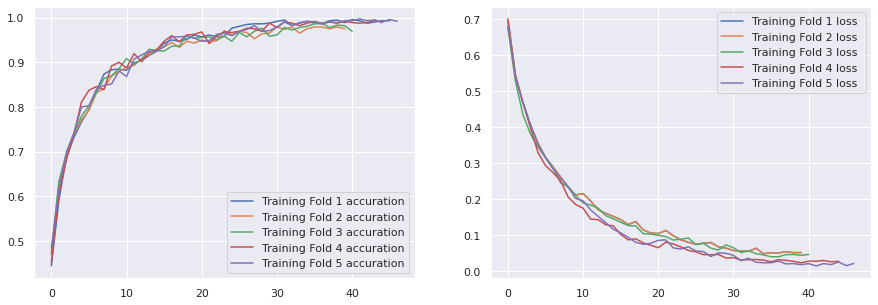

In [25]:
fig, (ax1, ax2) =  plt.subplots( ncols=2, sharex=True)
ax1.plot(model_history[0].history['accuracy'], label='Training Fold 1 accuration')
ax1.plot(model_history[1].history['accuracy'], label='Training Fold 2 accuration')
ax1.plot(model_history[2].history['accuracy'], label='Training Fold 3 accuration')
ax1.plot(model_history[3].history['accuracy'], label='Training Fold 4 accuration')
ax1.plot(model_history[4].history['accuracy'], label='Training Fold 5 accuration')
ax1.legend()
ax2.plot(model_history[1].history['loss'], label='Training Fold 1 loss')
ax2.plot(model_history[1].history['loss'], label='Training Fold 2 loss')
ax2.plot(model_history[2].history['loss'], label='Training Fold 3 loss')
ax2.plot(model_history[3].history['loss'], label='Training Fold 4 loss ')
ax2.plot(model_history[4].history['loss'], label='Training Fold 5 loss')
ax2.legend()
plt.show()

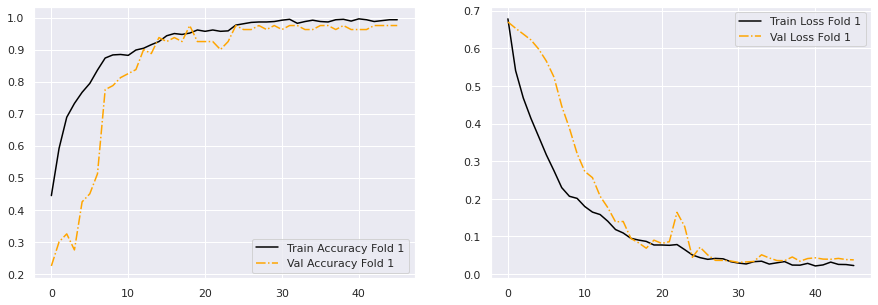

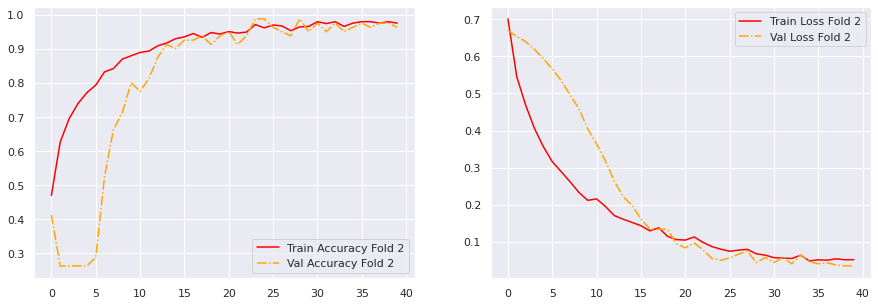

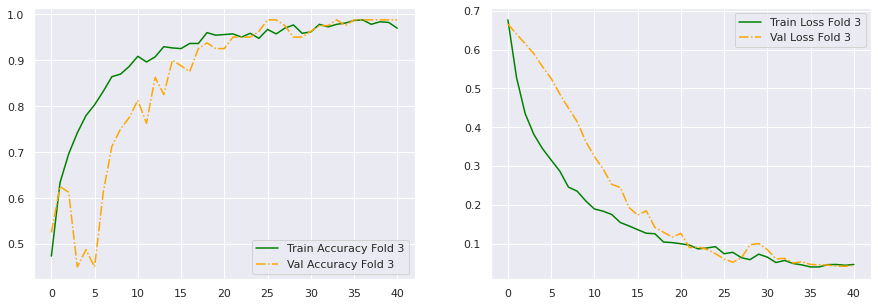

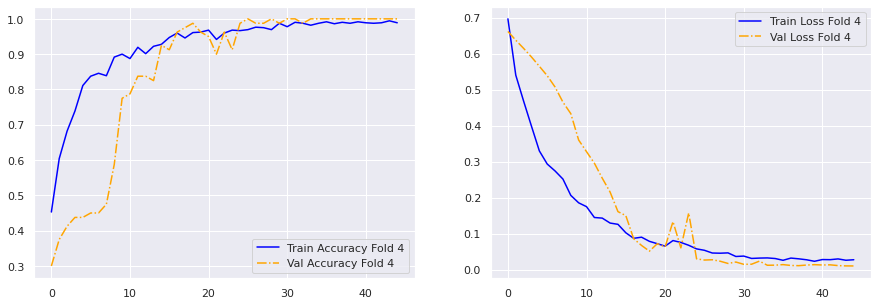

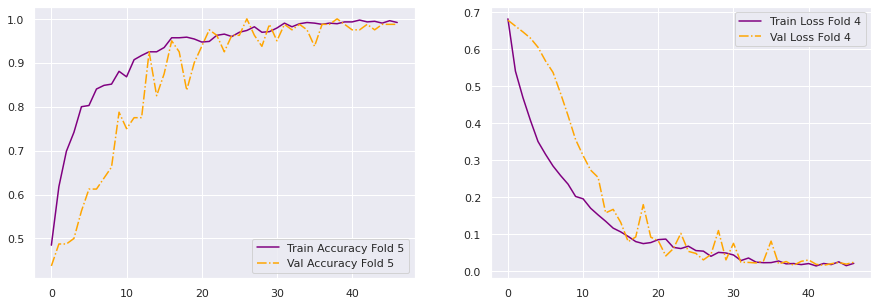

In [26]:

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt1.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt2.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red')
plt1.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red')
plt2.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green')
plt1.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green')
plt2.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()


fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue')
plt1.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue')
plt2.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='purple')
plt1.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[4].history['loss'], label='Train Loss Fold 4', color='purple')
plt2.plot(model_history[4].history['val_loss'], label='Val Loss Fold 4', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

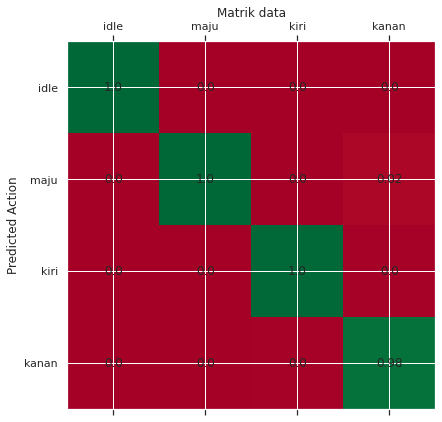

In [27]:

MODEL_NAME ='/content/subjek1LSTM.h5' 

#CLIP = True # if your model was trained with np.clip to clip  values
CLIP = False
CLIP_VAL = 8  # if above, what was the value +/-

model = tf.keras.models.load_model(MODEL_NAME)

VALDIR = '/content/drive/MyDrive/Colab Notebooks/data8'
ACTIONS =  ["idle","maju","kiri", "kanan"]
PRED_BATCH = 32


def get_val_data(valdir, action, batch_size):

   # argmax_dict = {0: 0, 1: 0, 2: 0,3:0}
    argmax_dict = {2: 0, 0: 0, 1: 0,3:0}
    raw_pred_dict = {0: 0, 1: 0, 2: 0,3:0}

    action_dir = os.path.join(valdir, action)
    for session_file in os.listdir(action_dir):
        filepath = os.path.join(action_dir,session_file)
        if CLIP:
            data = np.clip(np.load(filepath), -CLIP_VAL, CLIP_VAL) / CLIP_VAL
            #print(data)
        else:
            data = np.load(filepath) 
        preds = model.predict([data.reshape(-1, 8, 60)], batch_size=batch_size)
        
        for pred in preds:
            argmax = np.argmax(pred)
            argmax_dict[argmax] += 1
            for idx,value in enumerate(pred):
                raw_pred_dict[idx] += value
    
    argmax_pct_dict = {}
    for i in argmax_dict:
        total = 0
        correct = argmax_dict[i]
        for ii in argmax_dict:
            total += argmax_dict[ii]
        argmax_pct_dict[i] = round(correct/total, 4)
    return argmax_dict, raw_pred_dict, argmax_pct_dict


def make_conf_mat(none,left,forward, right):
    action_dict = {"idle":none,"maju": forward, "kiri": left, "kanan": right}
    action_conf_mat = pd.DataFrame(action_dict)
    actions = [i for i in action_dict]

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    ax.matshow(action_conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    for idx, i in enumerate(action_dict):
        for idx2, ii in enumerate(action_dict[i]):
            ax.text(idx, idx2, f"{round(float(action_dict[i][ii]),2)}", va='center', ha='center')
    # Rotate the tick labels and set their alignment.
    
    plt.title("Matrik data")
    plt.ylabel("Predicted Action")
    fig.tight_layout()
    plt.show()



forward_argmax_dict, forward_raw_pred_dict, forward_argmax_pct_dict = get_val_data(VALDIR, "maju", PRED_BATCH)
none_argmax_dict, none_raw_pred_dict, none_argmax_pct_dict = get_val_data(VALDIR, "idle", PRED_BATCH)
left_argmax_dict, left_raw_pred_dict, left_argmax_pct_dict = get_val_data(VALDIR, "kiri", PRED_BATCH)
right_argmax_dict, right_raw_pred_dict, right_argmax_pct_dict = get_val_data(VALDIR, "kanan", PRED_BATCH)
make_conf_mat(none_argmax_pct_dict,forward_argmax_pct_dict,left_argmax_pct_dict,  right_argmax_pct_dict)



In [28]:
x_train,x_test,y_train,y_test=train_test_split(train2_X,train_y,test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 8, 60)
(200, 8, 60)
(800, 4)
(200, 4)


roc_auc: 1.0


<Figure size 1080x360 with 0 Axes>

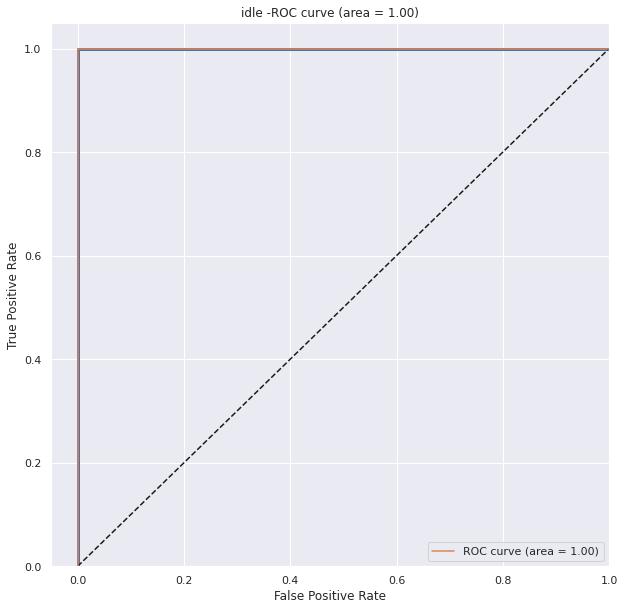

<Figure size 1080x360 with 0 Axes>

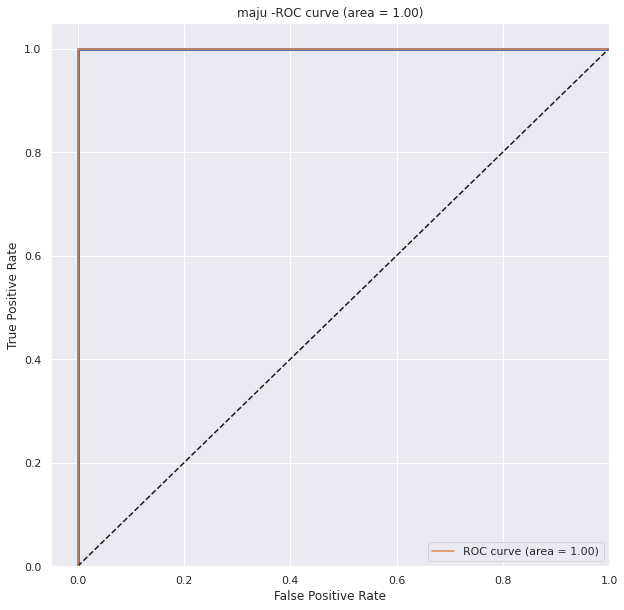

<Figure size 1080x360 with 0 Axes>

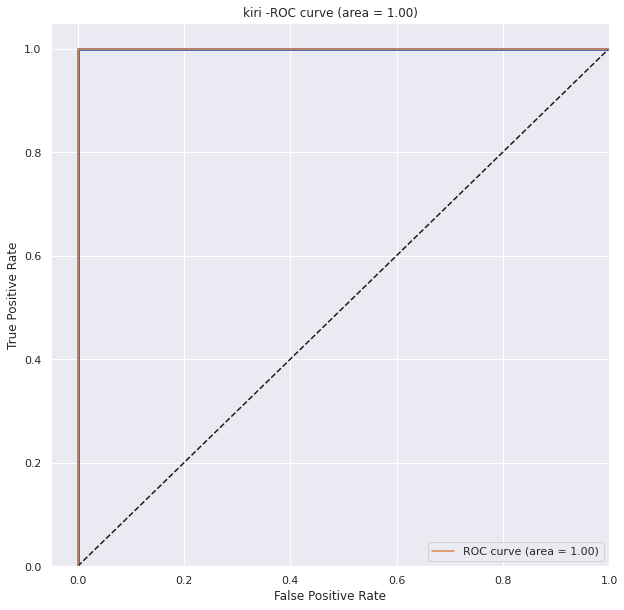

<Figure size 1080x360 with 0 Axes>

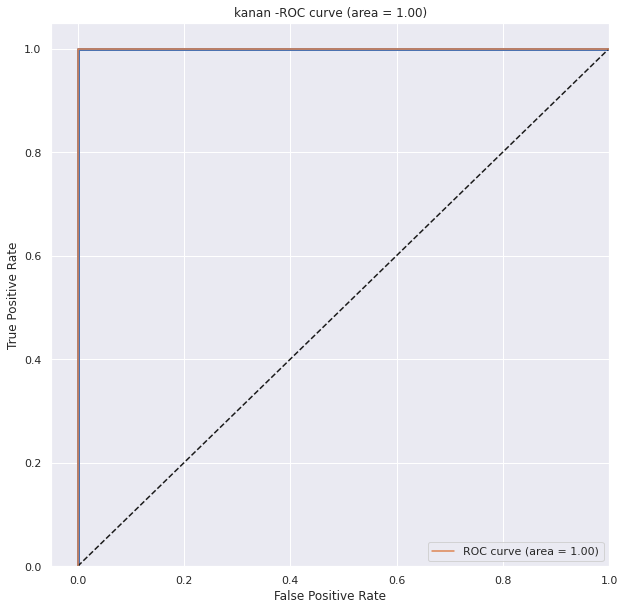

In [29]:
from sklearn.metrics import roc_curve, auc

#y_score = clf.decision_function(xval)
y_score = model.predict(x_test)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
    
print("roc_auc:",sum(roc_auc.values())/4)
ACTIONS =  ["idle","maju","kiri", "kanan"]
for i in range(0,4):
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    #plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % ACTIONS[i])
    plt.title('%s -ROC curve (area = %0.2f)' % (ACTIONS[i],roc_auc[i]))
    
    plt.legend(loc="lower right")
    plt.show()
    

#ML

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

from scipy import signal
from scipy.fft import fftshift
import numpy as np

import os
import random
import time
import os
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics import multilabel_confusion_matrix
import time

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [31]:
train_X = np.array(train_X).reshape(reshape3)
train_y = np.array(train_y)

x_train,x_test,y_train,y_test=train_test_split(train_X,train_y,test_size=0.2,random_state = np.random.randint(1,1000, 1)[0] )
x_train = np.asarray(x_train)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train = [np.concatenate(i) for i in x_train]
x_test = [np.concatenate(i) for i in x_test]
x_train,x_test,y_train,y_test=train_test_split(train_X,train_y,test_size=0.2,random_state = np.random.randint(1,1000, 1)[0] )
x_train = np.asarray(x_train)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train = [np.concatenate(i) for i in x_train]
x_test = [np.concatenate(i) for i in x_test]

(800, 8, 60)
(200, 8, 60)
(800, 4)
(200, 4)
(800, 8, 60)
(200, 8, 60)
(800, 4)
(200, 4)


In [32]:
sgd = SGDClassifier()
lr = LogisticRegression()
rf = RandomForestClassifier()
ld = LinearDiscriminantAnalysis()
sv = SVC()
ada= AdaBoostClassifier()
kn = KNeighborsClassifier()
GU = GaussianNB()


clf1 =OneVsRestClassifier(sgd)
clf2 =OneVsRestClassifier(lr)
clf3 =OneVsRestClassifier(rf)
clf4 =OneVsRestClassifier(ld)
clf5 =OneVsRestClassifier(sv)  
clf6 =OneVsRestClassifier(ada) 
clf7 =OneVsRestClassifier(kn) 
clf8 =OneVsRestClassifier(GU) 

start=time.time()

clf1.fit(x_train,y_train)
clf2.fit(x_train,y_train)
clf3.fit(x_train,y_train)
clf4.fit(x_train,y_train)
clf5.fit(x_train,y_train)
clf6.fit(x_train,y_train)
clf7.fit(x_train,y_train)
clf8.fit(x_train,y_train)



predictions1 = clf1.predict(x_test)
predictions2 = clf2.predict(x_test)
predictions3 = clf3.predict(x_test)
predictions4 = clf4.predict(x_test)
predictions5 = clf5.predict(x_test)
predictions6 = clf6.predict(x_test)
predictions7 = clf7.predict(x_test)
predictions8 = clf8.predict(x_test)

# accuracy
print("-------------------------")
print( "SGD")
print("Accuracy = ",accuracy_score(y_test,predictions1))
print("Hamming Loss = ",hamming_loss(y_test,predictions1))
print("label_ranking_average_precision_score",label_ranking_average_precision_score(y_test,predictions1))

# accuracy
print("-------------------------")
print( "LR")
print("Accuracy = ",accuracy_score(y_test,predictions2))
print("Hamming Loss = ",hamming_loss(y_test,predictions2))
print("label_ranking_average_precision_score",label_ranking_average_precision_score(y_test,predictions2))

# accuracy
print("-------------------------")
print( "RF")
print("Accuracy = ",accuracy_score(y_test,predictions3))
print("Hamming Loss = ",hamming_loss(y_test,predictions3))
print("label_ranking_average_precision_score",label_ranking_average_precision_score(y_test,predictions3))

# accuracy
print("-------------------------")
print( "LD")
print("Accuracy = ",accuracy_score(y_test,predictions4))
print("Hamming Loss = ",hamming_loss(y_test,predictions4))
print("label_ranking_average_precision_score",label_ranking_average_precision_score(y_test,predictions4))

# accuracy
print("-------------------------")
print( "SV")
print("Accuracy = ",accuracy_score(y_test,predictions5))
print("Hamming Loss = ",hamming_loss(y_test,predictions5))
print("label_ranking_average_precision_score",label_ranking_average_precision_score(y_test,predictions5))

# accuracy
print("-------------------------")
print( "AD")
print("Accuracy = ",accuracy_score(y_test,predictions6))
print("Hamming Loss = ",hamming_loss(y_test,predictions6))
print("label_ranking_average_precision_score",label_ranking_average_precision_score(y_test,predictions6))
# accuracy
print("-------------------------")
print( "KN")
print("Accuracy = ",accuracy_score(y_test,predictions7))
print("Hamming Loss = ",hamming_loss(y_test,predictions7))
print("label_ranking_average_precision_score",label_ranking_average_precision_score(y_test,predictions7))
# accuracy
print("-------------------------")
print( "GU")
print("Accuracy = ",accuracy_score(y_test,predictions8))
print("Hamming Loss = ",hamming_loss(y_test,predictions8))
print("label_ranking_average_precision_score",label_ranking_average_precision_score(y_test,predictions8))

print('training time taken: ',round(time.time()-start,0),'seconds')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


-------------------------
SGD
Accuracy =  0.7
Hamming Loss =  0.08
label_ranking_average_precision_score 0.79625
-------------------------
LR
Accuracy =  0.805
Hamming Loss =  0.0525
label_ranking_average_precision_score 0.86625
-------------------------
RF
Accuracy =  0.905
Hamming Loss =  0.02375
label_ranking_average_precision_score 0.93125
-------------------------
LD
Accuracy =  0.5
Hamming Loss =  0.22
label_ranking_average_precision_score 0.6674999999999999
-------------------------
SV
Accuracy =  0.525
Hamming Loss =  0.12375
label_ranking_average_precision_score 0.64375
-------------------------
AD
Accuracy =  0.71
Hamming Loss =  0.0775
label_ranking_average_precision_score 0.7975
-------------------------
KN
Accuracy =  0.94
Hamming Loss =  0.02875
label_ranking_average_precision_score 0.955
-------------------------
GU
Accuracy =  0.24
Hamming Loss =  0.30125
label_ranking_average_precision_score 0.5420833333333331
training time taken:  10.0 seconds


['SGD', 'LR', 'RF', 'LDA', 'SVM', 'AD', 'KNN', 'GU']
[0.7, 0.805, 0.905, 0.5, 0.525, 0.71, 0.94, 0.24]


<BarContainer object of 8 artists>

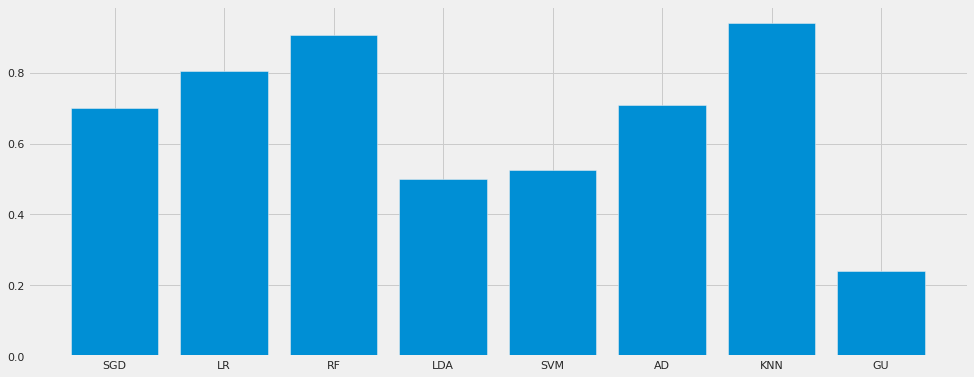

In [33]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

data = {'SGD': accuracy_score(y_test,predictions1), 'LR': accuracy_score(y_test,predictions2), 
        'RF': accuracy_score(y_test,predictions3), 'LDA': accuracy_score(y_test,predictions4),
        'SVM': accuracy_score(y_test,predictions5),'AD': accuracy_score(y_test,predictions6),
        'KNN': accuracy_score(y_test,predictions7),'GU': accuracy_score(y_test,predictions8),}
names = list(data.keys())
values = list(data.values())
print(names)
print(values)
plt.figure(figsize=(15, 6))
plt.bar(names,values)



#RF

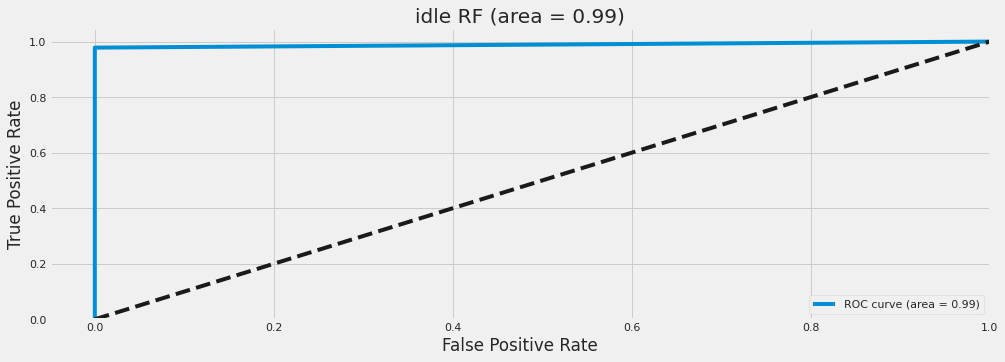

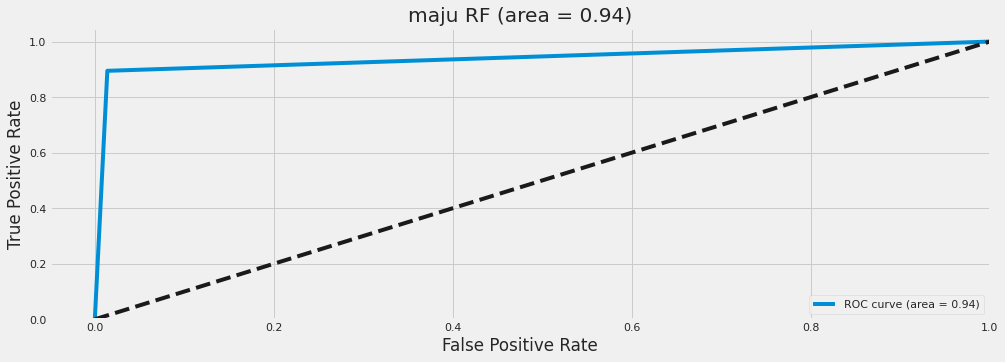

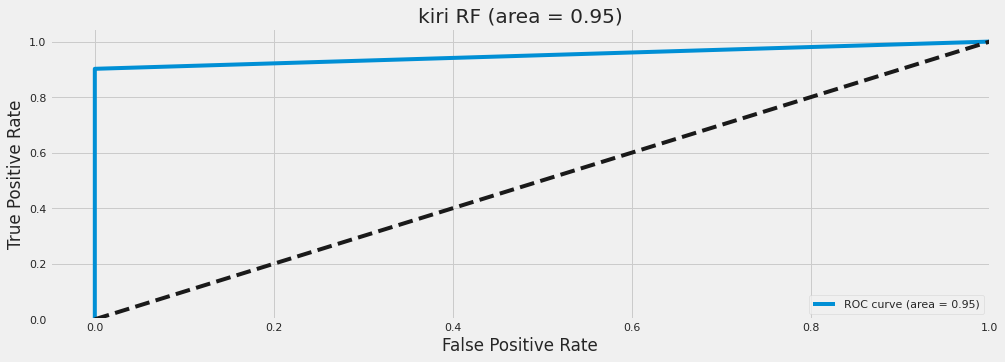

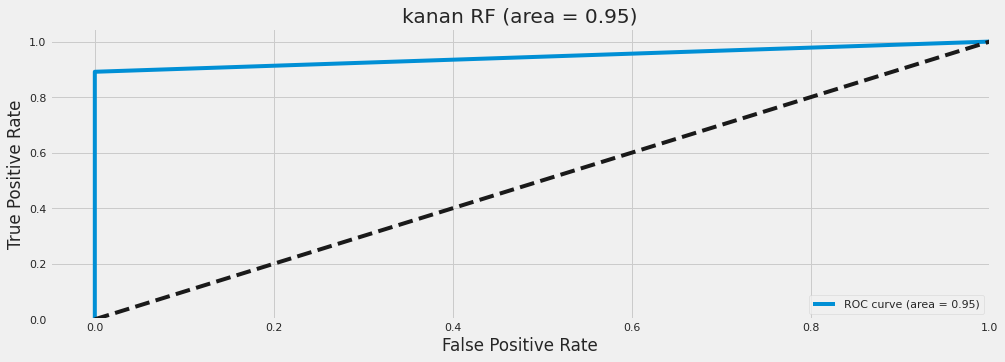

In [34]:
from sklearn.metrics import roc_curve, auc
y_score = clf3.predict(x_test)
#y_score = clf.predict(xval)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
ACTIONS =  ["idle","maju","kiri", "kanan"]
# Plot of a ROC curve for a specific class
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic example')
    plt.title('%s RF (area = %0.2f)' % (ACTIONS[i],roc_auc[i]))
    plt.legend(loc="lower right")
    plt.show()

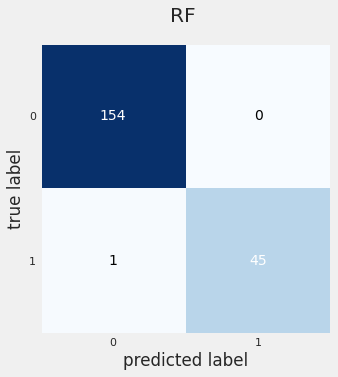

In [35]:
from sklearn.metrics import multilabel_confusion_matrix
cm=multilabel_confusion_matrix(y_test, predictions3)

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm[0])
plt.title('RF ' )
plt.show()

#KNN

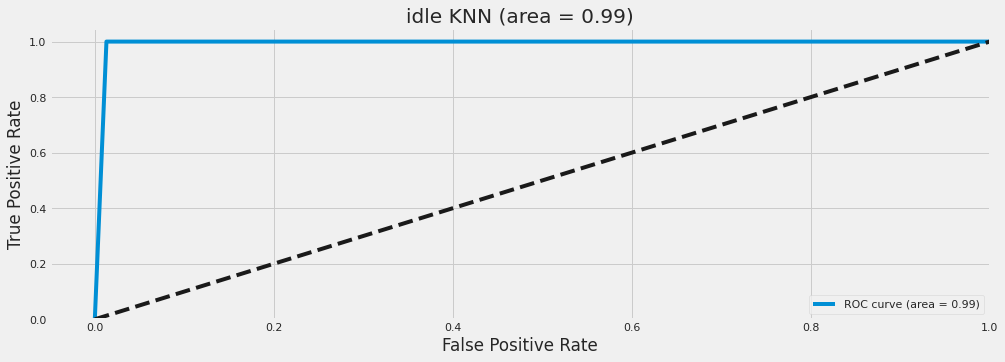

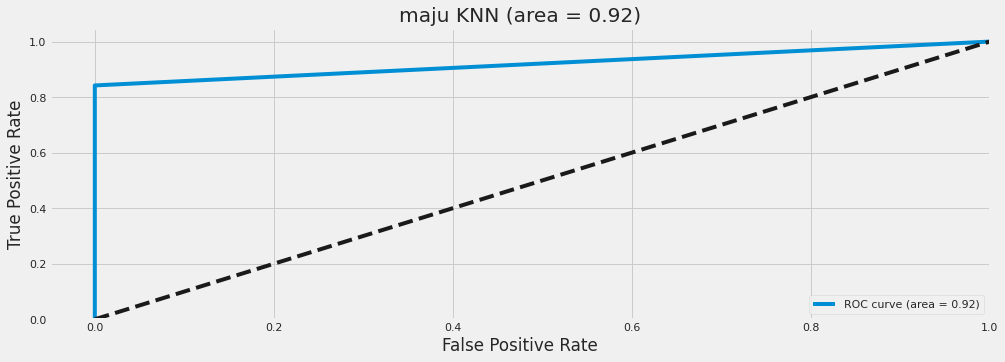

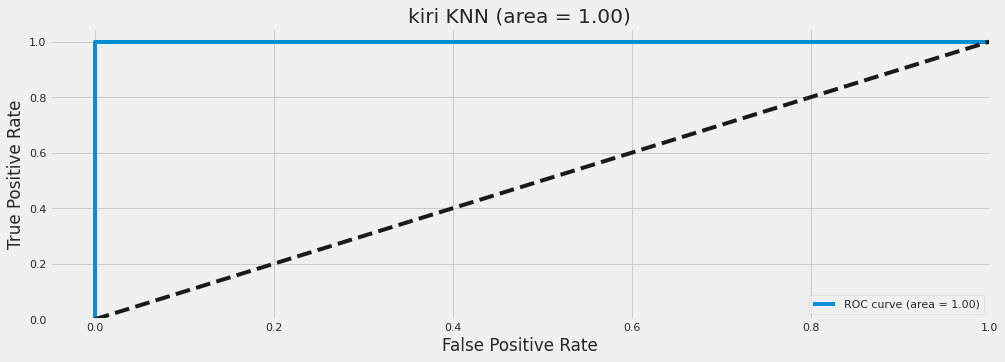

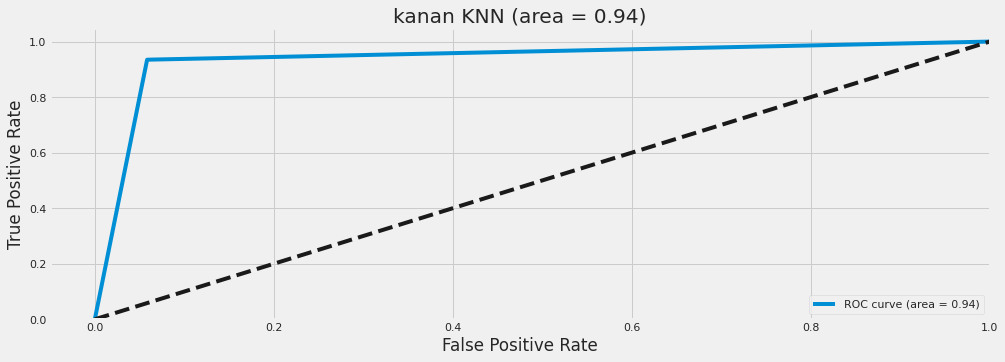

In [36]:
from sklearn.metrics import roc_curve, auc
y_score = clf7.predict(x_test)
#y_score = clf.predict(xval)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
ACTIONS =  ["idle","maju","kiri", "kanan"]
# Plot of a ROC curve for a specific class
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic example')
    plt.title('%s KNN (area = %0.2f)' % (ACTIONS[i],roc_auc[i]))
    plt.legend(loc="lower right")
    plt.show()

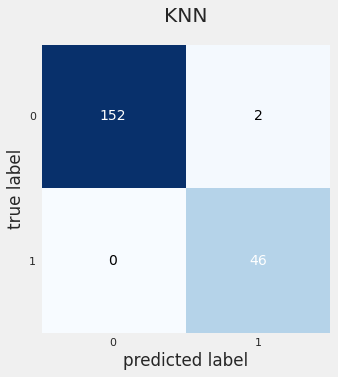

In [37]:
from sklearn.metrics import multilabel_confusion_matrix
cm=multilabel_confusion_matrix(y_test, predictions7)

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm[0])
plt.title('KNN' )
plt.show()